In [4]:
# Installer les bibliothèques nécessaires
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap --quiet


In [5]:
# Imports et configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Style de visualisation
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette('viridis', 5)


## visualisation des distributions

In [6]:
print(" Chargement des données nettoyées...")

df = pd.read_csv('data_cleaned.csv')
print(f" Données chargées: {df.shape[0]} lignes, {df.shape[1]} colonnes")
display(df.head())

 Chargement des données nettoyées...
 Données chargées: 1941 lignes, 14 colonnes


,type,area,property_state,rooms,bedrooms,bathrooms,jardin,piscine,cuisine_equiped,terrasse,garage,quartier,price_de_m2,price
0,villa,550.0,Moins d'un an,6.0,5.0,4.0,1.0,1.0,1.0,1.0,1.0,Souissi,25454.545455,14000000.0
1,appartement,107.0,NaN,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,Agdal,18504.672897,1980000.0
2,villa,791.0,20-30 ans,8.0,5.0,3.0,1.0,1.0,0.0,1.0,0.0,Riyad,11251.580278,8900000.0
3,NaN,4800.0,NaN,22.0,10.0,5.0,0.0,1.0,1.0,0.0,1.0,Souissi,25000.000000,120000000.0
4,villa,622.0,NaN,8.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,Riyad,12057.877814,7500000.0


In [7]:
# Analyse exploratoire – info & stats
print("\n Analyse exploratoire des données...")

print("\n Informations sur les colonnes:")
df.info()

print("\n Statistiques descriptives:")
display(df.describe().round(2))

print("\n Valeurs manquantes par colonne:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])



 Analyse exploratoire des données...

 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             1811 non-null   object 
 1   area             1941 non-null   float64
 2   property_state   622 non-null    object 
 3   rooms            1468 non-null   float64
 4   bedrooms         1482 non-null   float64
 5   bathrooms        1107 non-null   float64
 6   jardin           1070 non-null   float64
 7   piscine          1070 non-null   float64
 8   cuisine_equiped  1070 non-null   float64
 9   terrasse         1070 non-null   float64
 10  garage           1070 non-null   float64
 11  quartier         1941 non-null   object 
 12  price_de_m2      1941 non-null   float64
 13  price            1941 non-null   float64
dtypes: float64(11), object(3)
memory usage: 212.4+ KB

 Statistiques descriptives:


,area,rooms,bedrooms,bathrooms,jardin,piscine,cuisine_equiped,terrasse,garage,price_de_m2,price
count,1941.00,1468.00,1482.00,1107.00,1070.00,1070.00,1070.00,1070.00,1070.00,1.941000e+03,1.941000e+03
mean,393.21,5.73,4.05,2.89,0.47,0.22,0.45,0.61,0.75,5.404110e+07,7.841923e+10
std,671.34,25.64,25.42,1.59,0.50,0.41,0.50,0.49,0.43,1.756804e+09,3.405038e+12
min,10.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.069000e+01,6.000000e+03
25%,97.00,3.00,2.00,2.00,0.00,0.00,0.00,0.00,0.25,1.120000e+04,1.500000e+06
50%,142.00,4.00,3.00,3.00,0.00,0.00,0.00,1.00,1.00,1.571429e+04,2.600000e+06
75%,300.00,6.00,4.00,4.00,1.00,0.00,1.00,1.00,1.00,2.047244e+04,5.500000e+06
max,6759.00,982.00,980.00,12.00,1.00,1.00,1.00,1.00,1.00,6.818182e+10,1.500000e+14



 Valeurs manquantes par colonne:
type                130
property_state     1319
rooms               473
bedrooms            459
bathrooms           834
jardin              871
piscine             871
cuisine_equiped     871
terrasse            871
garage              871
dtype: int64


Valeurs extrêmes après nettoyage:
Max price: 9950000.0
Max price/m²: 92857.14285714286


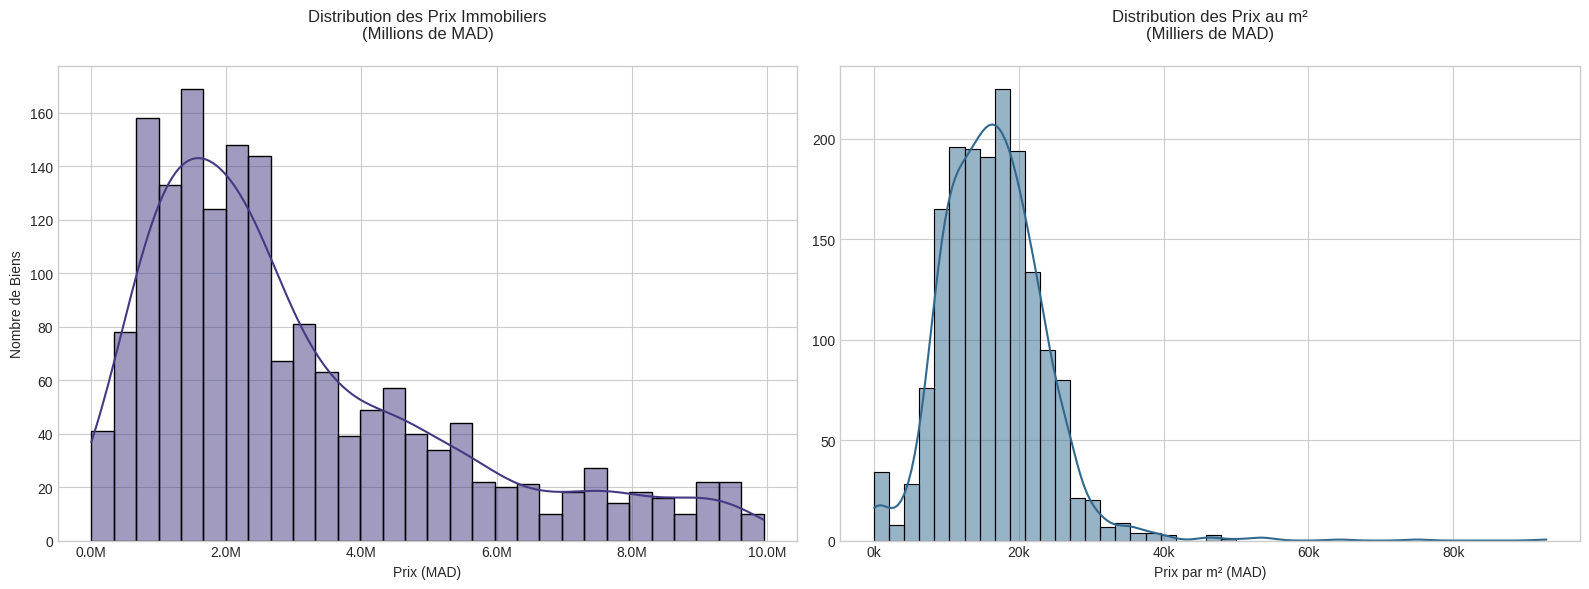

<Figure size 640x480 with 0 Axes>

In [8]:

# 1. Nettoyage approfondi
df_clean = df.copy()

# Conversion sécurisée et remplacement des infinis
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean['price_de_m2'] = pd.to_numeric(df_clean['price_de_m2'], errors='coerce')
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

# Filtrage final
df_clean = df_clean[
    (df_clean['price'] > 0) &
    (df_clean['price_de_m2'] > 0) &
    (df_clean['price'] < 10_000_000) &
    (df_clean['price_de_m2'] < 100_000)
].copy()

# 2. Vérification ultime
print("Valeurs extrêmes après nettoyage:")
print("Max price:", df_clean['price'].max())
print("Max price/m²:", df_clean['price_de_m2'].max())
# Graphique 2 - Prix/m²
# 2. Visualisation professionnelle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique Prix
sns.histplot(
    data=df_clean,
    x='price',
    bins=30,
    kde=True,
    color=colors[0],
    ax=ax1
)
ax1.set_title('Distribution des Prix Immobiliers\n(Millions de MAD)', pad=20)
ax1.set_xlabel('Prix (MAD)')
ax1.set_ylabel('Nombre de Biens')
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Graphique Prix/m²
sns.histplot(
    data=df_clean,
    x='price_de_m2',
    bins=np.linspace(0, 50_000, 25),
    kde=True,
    color=colors[1],
    ax=ax2
)
ax2.set_title('Distribution des Prix au m²\n(Milliers de MAD)', pad=20)
ax2.set_xlabel('Prix par m² (MAD)')
ax2.set_ylabel('')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e3:.0f}k'))

plt.tight_layout()
plt.show()
plt.savefig('Distribution_des_Prix_au_m².png', dpi=300, bbox_inches='tight')

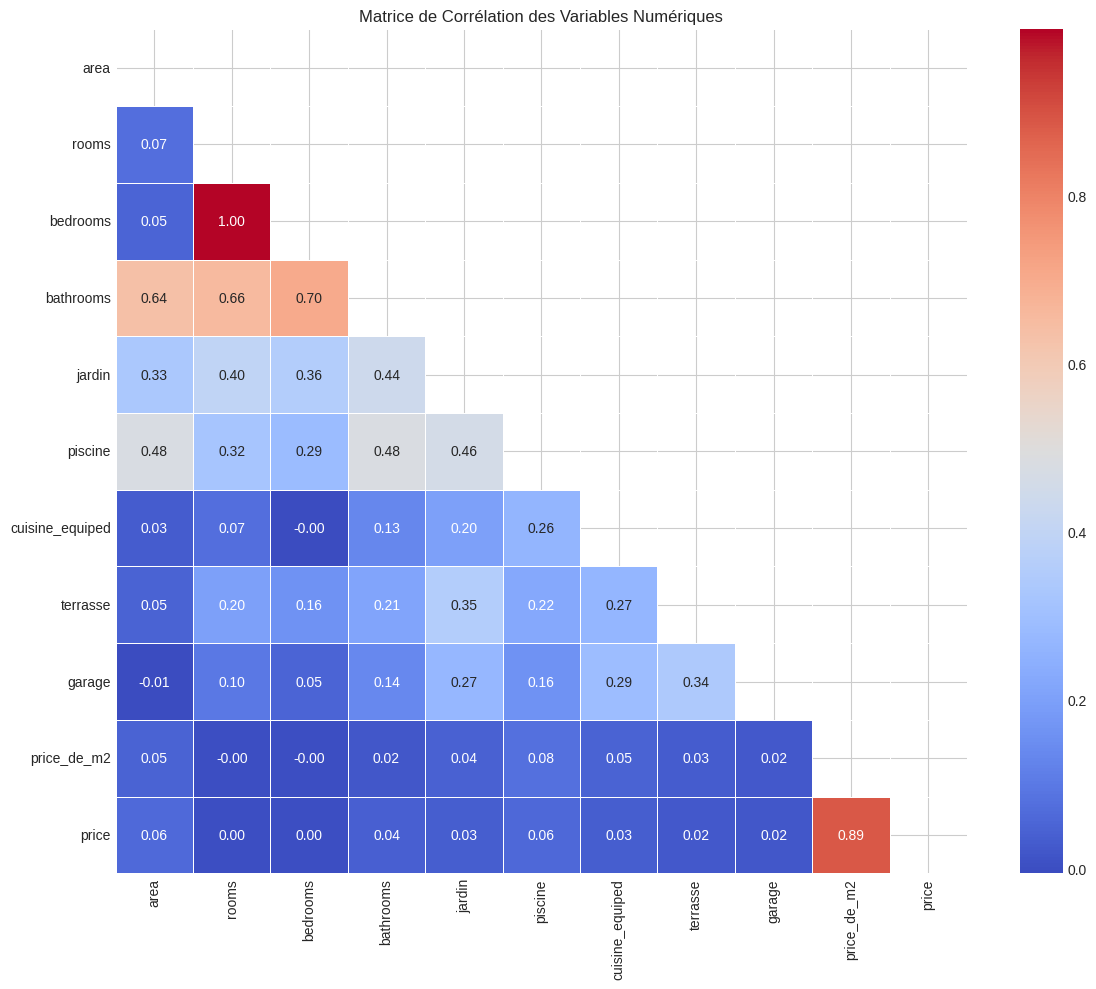

<Figure size 640x480 with 0 Axes>

In [9]:
# Matrice de corrélation
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de Corrélation des Variables Numériques')
plt.tight_layout()
plt.show()
plt.savefig('Matrice_de_Corrélation_des_Variables_Numériques.png', dpi=300, bbox_inches='tight')


## modélisation

In [10]:
# Prepare features and target
X = df.drop(columns='price')
y = df['price']

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=['property_state', 'type', 'quartier'], drop_first=True)

# Handle missing values in features
# Impute missing values (replace NaN with mean)
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns) # Impute on X before splitting

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Modèles à comparer
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
   "XGBoost": XGBRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "SVR (RBF Kernel)": SVR(kernel='rbf')
}

In [12]:
#  Entraînement et évaluation
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append({
        "Model": name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R² Score": round(r2, 4)
    })

In [13]:
#  Visualisation (Random Forest )
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

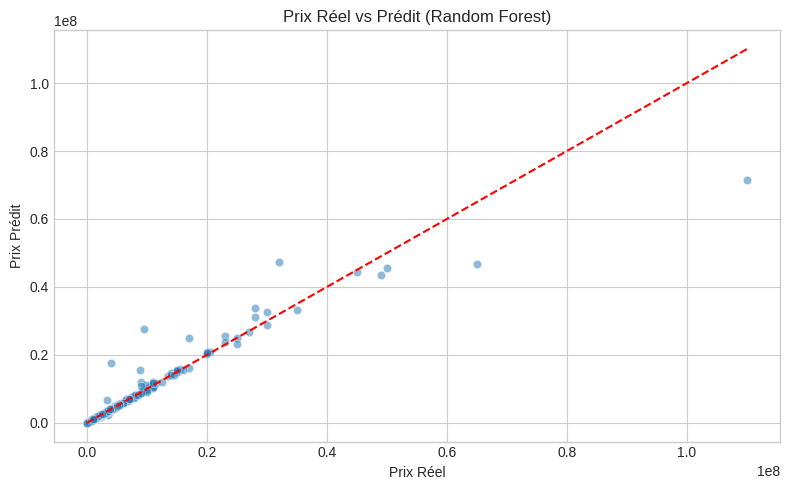

<Figure size 640x480 with 0 Axes>

In [14]:
#  Prix réel vs prédit (Random Forest )
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Prix Réel")
plt.ylabel("Prix Prédit")
plt.title("Prix Réel vs Prédit (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('Prix_Réel_vs_Prédit_Random_Forest.png', dpi=300, bbox_inches='tight')

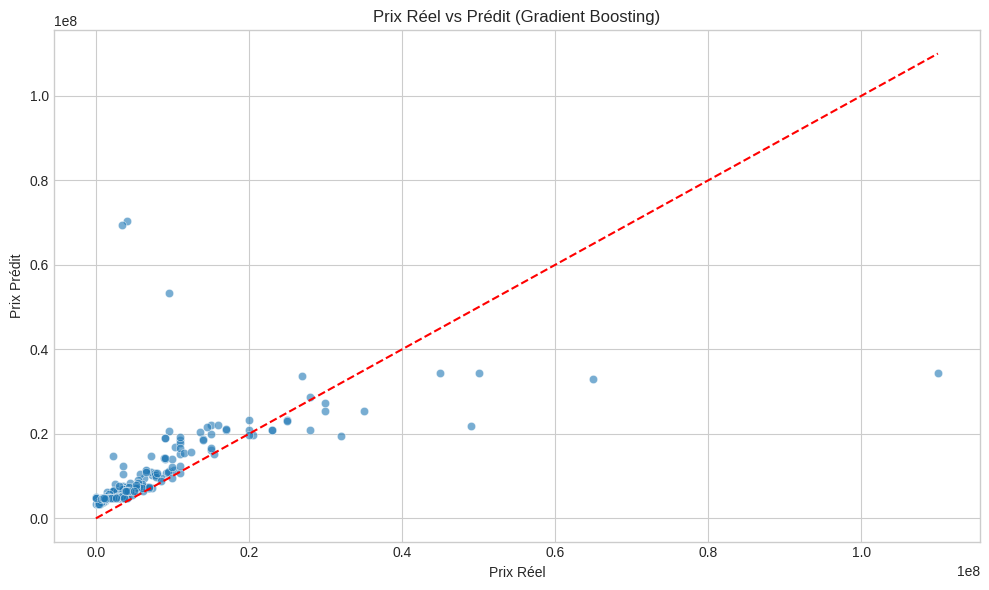

<Figure size 640x480 with 0 Axes>

In [15]:
#  Visualisation (Gradient Boosting)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
#  Prix réel vs prédit (Gradient Boosting)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=gb_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Prix Réel")
plt.ylabel("Prix Prédit")
plt.title("Prix Réel vs Prédit (Gradient Boosting)")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('Prix_Réel_vs_Prédit_Gradient_Boosting.png', dpi=300, bbox_inches='tight')


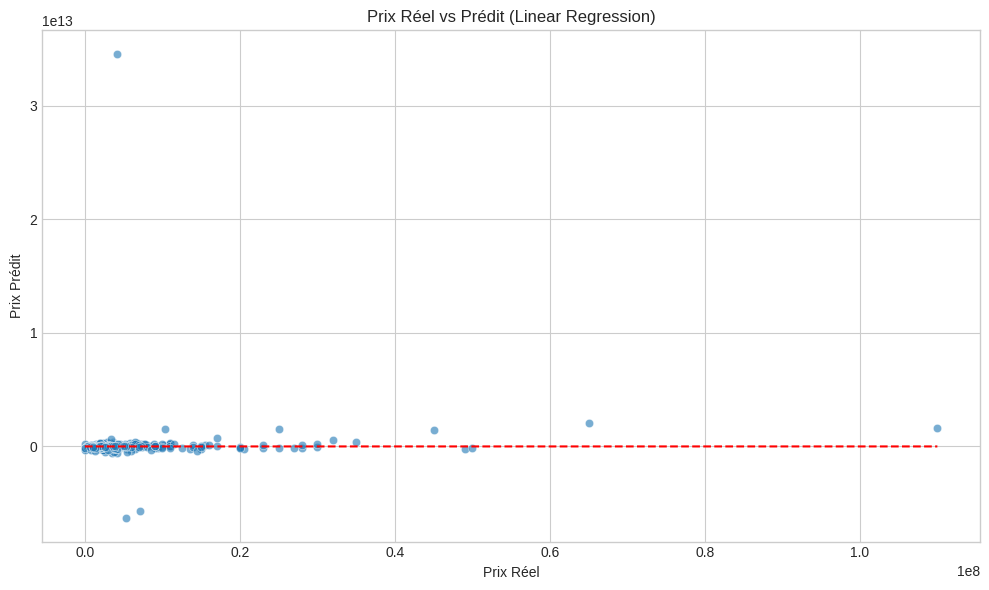

<Figure size 640x480 with 0 Axes>

In [16]:
# 📈 Visualisation (Linear Regression)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
#  Prix réel vs prédit (Linear Regression)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Prix Réel")
plt.ylabel("Prix Prédit")
plt.title("Prix Réel vs Prédit (Linear Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('Prix_Réel_vs_Prédit_Linear_Regression.png', dpi=300, bbox_inches='tight')


In [17]:
#  Affichage des performances
results_df = pd.DataFrame(results).sort_values(by="R² Score")
print("📊 Comparaison des Modèles :")
print(results_df.to_string(index=False))

📊 Comparaison des Modèles :
            Model          MAE         RMSE      R² Score
Linear Regression 2.336569e+11 1.821718e+12 -4.069256e+10
 Lasso Regression 2.336564e+11 1.821717e+12 -4.069250e+10
 Ridge Regression 2.246152e+11 1.741242e+12 -3.717672e+10
 SVR (RBF Kernel) 3.758888e+06 9.403133e+06 -8.420000e-02
Gradient Boosting 3.971542e+06 7.748003e+06  2.639000e-01
          XGBoost 8.832873e+05 5.897781e+06  5.735000e-01
    KNN Regressor 1.412426e+06 5.607093e+06  6.145000e-01
    Random Forest 4.946308e+05 2.691870e+06  9.111000e-01


In [18]:
print(results_df)  # Check your data structure
print(results_df.columns)  # Verify column names match what you're using

               Model           MAE          RMSE      R² Score
0  Linear Regression  2.336569e+11  1.821718e+12 -4.069256e+10
2   Lasso Regression  2.336564e+11  1.821717e+12 -4.069250e+10
1   Ridge Regression  2.246152e+11  1.741242e+12 -3.717672e+10
7   SVR (RBF Kernel)  3.758888e+06  9.403133e+06 -8.420000e-02
5  Gradient Boosting  3.971542e+06  7.748003e+06  2.639000e-01
3            XGBoost  8.832873e+05  5.897781e+06  5.735000e-01
6      KNN Regressor  1.412426e+06  5.607093e+06  6.145000e-01
4      Random Forest  4.946308e+05  2.691870e+06  9.111000e-01
Index(['Model', 'MAE', 'RMSE', 'R² Score'], dtype='object')


In [20]:
!pip install plotly ipywidgets
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from google.colab import output

# Enable Plotly in Colab
output.enable_custom_widget_manager()

# --------------------------------------------------
# Assuming results_df exists with these columns:
# ['Model', 'R² Score', 'MAE', 'RMSE']
# --------------------------------------------------

# 1. Title and Data Table
title = widgets.HTML("<h1 style='text-align:center; color:#003087'>Rabat Immobilier Prediction Dashboard</h1>")
table_title = widgets.HTML("<h2 style='color:#003087'>📊 Comparaison des Modèles</h2>")

# Create interactive table
table = widgets.Output()
with table:
    display(results_df)  # Show raw data table first
    fig = px.bar(results_df, x='Model', y='R² Score', title='R² Scores')
    fig.show()

# 2. Visualization Section
viz_title = widgets.HTML("<h2 style='color:#003087'>Visualisation des Performances</h2>")

# Dropdown to select metric
metric_dropdown = widgets.Dropdown(
    options=['R² Score', 'MAE', 'RMSE'],
    value='R² Score',
    description='Metric:',
    style={'description_width': 'initial'}
)

# Interactive plot output
plot_output = widgets.Output()

def update_plot(metric):
    plot_output.clear_output()
    with plot_output:
        fig = px.bar(
            results_df,
            x='Model',
            y=metric,
            title=f'{metric} par Modèle',
            color='Model',
            text=metric,
            height=400
        ).update_traces(textposition='outside')
        fig.show()

# Initial plot
update_plot(metric_dropdown.value)

# Connect dropdown to plot update
metric_dropdown.observe(
    lambda change: update_plot(change.new) if change.name == 'value' else None,
    names='value'
)

# 3. Scatter Plot for Model Comparison
scatter_title = widgets.HTML("<h2 style='color:#003087'>Comparaison R² vs MAE</h2>")
scatter_output = widgets.Output()

with scatter_output:
    fig = px.scatter(
        results_df,
        x='R² Score',
        y='MAE',
        size='RMSE',
        color='Model',
        hover_name='Model',
        title='R² Score vs MAE avec RMSE comme taille'
    )
    fig.show()

# Arrange all components
dashboard = widgets.VBox([
    title,
    table_title,
    table,
    viz_title,
    metric_dropdown,
    plot_output,
    scatter_title,
    scatter_output
])

display(dashboard)